### 9-bus test system
 Definition of the initial 9-bus test system (originally presented in Paul M. Anderson; A. A. Fouad, "Power System Control and Stability" , IEEE, 2003, pp.i-xiv, doi: 10.1109/9780470545577.fmatter.)

### First time this should be run in terminal: 
Install libraries (if  you use uv add dependencies are added to pyproject.toml automatically, if you use uv pip install you need to add manually)

In [ ]:
# Create venv
uv venv
# Activate it
.\.venv\Scripts\activate
# Install packages in the venv
uv add highspy pyscipopt matplotlib pandas numpy cartopy
uv add jupyter
uv add pypsa

Comments:
I had some issues as the local repo is in a onedrive and i could not add pypsa and jupyter directly. 
what i needed to do was add all the other packages first and then clean cache and then add jupyter first and later add pypsa

### Importing and defining models

In [12]:
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [13]:
def create_9_bus_network():
    # Create network
    network = pypsa.Network()
    network.set_snapshots(range(1))
    #overwrite=overwrite
    # Set base MVA
    network.sbase = 100.0
    
    # Traditional IEEE 9-bus layout coordinates
    bus_coordinates = {
        1: (0, 0),      # Generator 1 (slack)
        2: (4, 0),      # Generator 2
        3: (2, 2),      # Generator 3
        4: (1, -1),     # Load bus
        5: (3, -1),     # Load bus
        6: (2, 0.5),    # Load bus
        7: (1, 1),      # Load bus
        8: (3, 1),      # Load bus
        9: (2, -1)      # Load bus
    }
    
    # Add buses with coordinates    
    for i in range(1, 10):
        bus_data = {
            "x": bus_coordinates[i][0],
            "y": bus_coordinates[i][1],
            "v_nom": 345,
            "v_mag_pu_set": 1.0,
            "v_mag_pu_min": 0.9,
            "v_mag_pu_max": 1.1,
            "type": "Slack" if i == 1 else "PV" if i in [2,3] else "PQ"
        }
        network.add("Bus", f"Bus {i}", **bus_data)
        
        # Add loads directly after creating each bus
        if i in [5, 7, 9]:
            load_p = {5: 90, 7: 100, 9: 125}[i]
            load_q = {5: 30, 7: 35, 9: 50}[i]
            network.add("Load", f"Load {i}", 
                    bus=f"Bus {i}",
                    p_set=load_p,
                    q_set=load_q)
        
    ## Add Generators
    gen_data = [
        {"bus": "Bus 1", "p_nom": 250, "p_min": 10, "p_set": 0, "q_min": -300, "q_max": 300},
        {"bus": "Bus 2", "p_nom": 300, "p_min": 10, "p_set": 163, "q_min": -300, "q_max": 300},
        {"bus": "Bus 3", "p_nom": 270, "p_min": 10, "p_set": 85, "q_min": -300, "q_max": 300}
    ]
    
    for i, gen in enumerate(gen_data):
        network.add("Generator", f"Gen {i+1}", **gen)
    
    ## Add Lines
    branch_data = [
        [1, 4, 0, 0.0576, 0, 250],
        [4, 5, 0.017, 0.092, 0.158, 250],
        [5, 6, 0.039, 0.17, 0.358, 150],
        [3, 6, 0, 0.0586, 0, 300],
        [6, 7, 0.0119, 0.1008, 0.209, 150],
        [7, 8, 0.0085, 0.072, 0.149, 250],
        [8, 2, 0, 0.0625, 0, 250],
        [8, 9, 0.032, 0.161, 0.306, 250],
        [9, 4, 0.01, 0.085, 0.176, 250]
    ]
    
    for i, branch in enumerate(branch_data):
        f_bus, t_bus, r, x, b, rate = branch
        network.add("Line", f"Line {i+1}",
                   bus0=f"Bus {f_bus}",
                   bus1=f"Bus {t_bus}",
                   r=r,
                   x=x,
                   b=b,
                   s_nom=rate)
    
    return network

### Running power flow simulations


In [14]:
n = create_9_bus_network() # create the network with some parameters

In [11]:
# Create figure with larger size
plt.figure(figsize=(12, 8))

# Plot network with enhanced details
n.plot(
    bus_sizes=0.3,          # Size of bus markers
    line_widths=2,          # Width of transmission lines
    bus_colors='red',       # Change bus color
    line_colors='blue',     # Line color
    title="IEEE 9-bus System",
    margin=0.15,            # Margin around the plot
    bus_labels=True,        # Show bus labels
    geomap=False           # Keep geomap off since we're using local coordinates
)

# Add grid and labels
plt.grid(True)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Ensure proper aspect ratio
plt.axis('equal')

# Add legend
plt.legend(['Buses', 'Lines'], loc='upper right')

plt.show()

TypeError: plot() got an unexpected keyword argument 'bus_labels'

<Figure size 1200x800 with 0 Axes>

In [ ]:
network.pf() # run the power flow

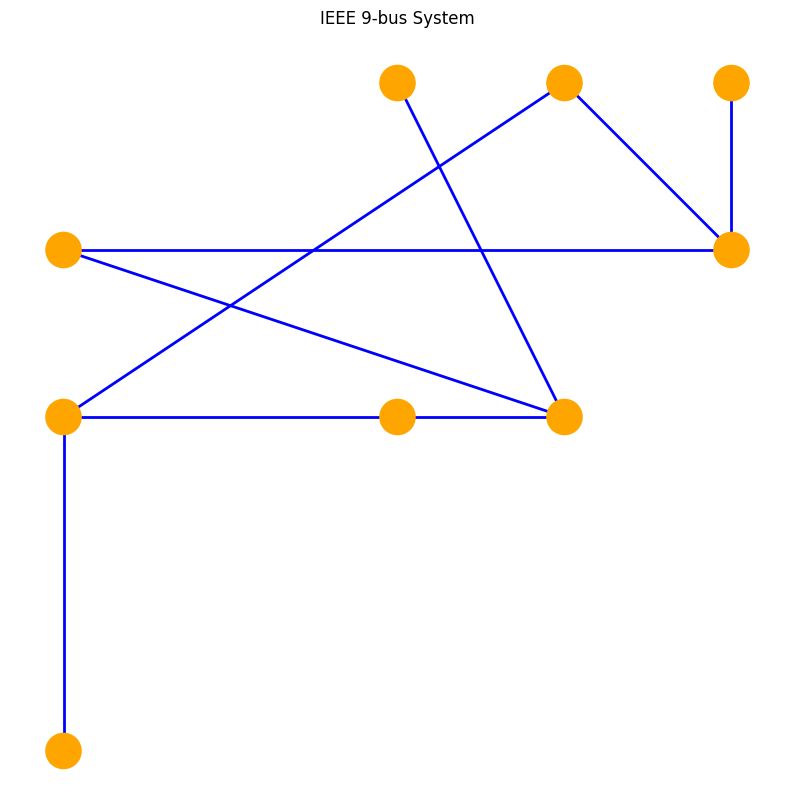

In [17]:
def create_test_network():
    # Create network
    network = pypsa.Network()
    
    # Set coordinates for buses (example layout)
    bus_coordinates = {
        1: (0, 0),      # Bus 1 at origin
        2: (20, 20),      # Bus 2 
        3: (10, 20),     # Bus 3
        4: (0, 10),     # Bus 4
        5: (10, 10),     # Bus 5
        6: (15, 10),     # Bus 6
        7: (0, 15),    # Bus 7
        8: (20, 15),      # Bus 8
        9: (15, 20)     # Bus 9
    }
    
    # Add buses with coordinates
    for i in range(1, 10):
        x, y = bus_coordinates[i]
        network.add("Bus", f"Bus {i}",
                   x=x,
                   y=y,
                   v_nom=345)
    
        ## Add Lines
    branch_data = [
        [1, 4, 0, 0.0576, 0, 250],
        [4, 5, 0.017, 0.092, 0.158, 250],
        [5, 6, 0.039, 0.17, 0.358, 150],
        [3, 6, 0, 0.0586, 0, 300],
        [6, 7, 0.0119, 0.1008, 0.209, 150],
        [7, 8, 0.0085, 0.072, 0.149, 250],
        [8, 2, 0, 0.0625, 0, 250],
        [8, 9, 0.032, 0.161, 0.306, 250],
        [9, 4, 0.01, 0.085, 0.176, 250]
    ]
    
    for i, branch in enumerate(branch_data):
        f_bus, t_bus, r, x, b, rate = branch
        network.add("Line", f"Line {i+1}",
                   bus0=f"Bus {f_bus}",
                   bus1=f"Bus {t_bus}",
                   r=r,
                   x=x,
                   b=b,
                   s_nom=rate)
    
    return network

# Create and plot network
network = create_test_network()

# Plot with more detailed settings
plt.figure(figsize=(10, 10))
network.plot(
    bus_sizes=0.3,
    line_widths=2,
    bus_colors='orange',
    line_colors='blue',
    title="IEEE 9-bus System",
    margin=0.15,
    geomap=False
)
plt.grid(True)
plt.axis('equal')
plt.show()